In [1]:
from pathlib import Path
import os
import pandas as pd

from tools.add_AR_cols import add_AR_cols
from data_treatment.box_creator import create_binary_box
import TinyAutoML as tam

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

os.chdir(root)

Here we import the whole cleaned dataset. It is 166 columns for 3692 rows.
We add Auto-lagged cols and the binary target

In [2]:
df = pd.read_csv('database.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = create_binary_box(df, relative_threshold = 0.20, box_length=30).set_index(['Date']).dropna(axis = 0)
df = add_AR_cols(df,7).dropna(axis = 0)
X,y = df.drop('Box', axis=1)[:'2020'], df['Box'][:'2020']

cut = int(len(y) * 0.8)

X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

Then we instantiate the MetaPipeline object, we fit it and look at the outputs and scores.



In [3]:
mpipe = tam.Estimator.MetaPipeline()
mpipe.fit(X_train,y_train, grid_search=True)

Correcting non-stationarity on the dataset...
Done.
Calculating columns to keep according to LASSO features selection


100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

	Done.
Training models
Training : 
----> rcf


----> Logistic Regression
----> Gaussian Naive Bayes
----> LDA
----> DTC
----> AdaBoost
	Done.
Results : 
The best estimator is rcf with a cross-validation accuracy (in Sample) of 0.6143149533393436


MetaPipeline()

In [4]:
mpipe.get_scores()


#mpipe.classification_report(X_train,y_train)

,mean
rcf,0.614315
Logistic Regression,0.581118
Gaussian Naive Bayes,0.589469
LDA,0.579369
DTC,0.548223
AdaBoost,0.568517


Correcting non-stationarity on the dataset...
Done.


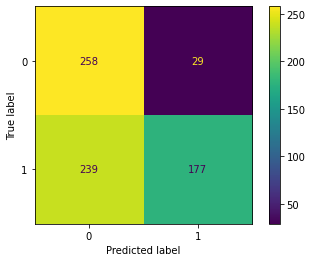

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test[17:],mpipe.predict(X_test))

Correcting non-stationarity on the dataset...
Done.


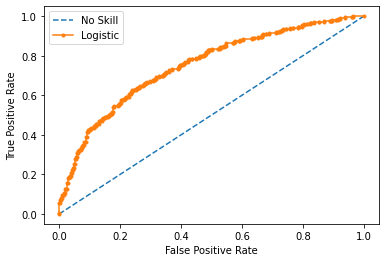

In [22]:
mpipe.roc_curve(X_test,y_test)

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test[17:],mpipe.predict(X_test))


Correcting non-stationarity on the dataset...
Done.


0.6088193456614509

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

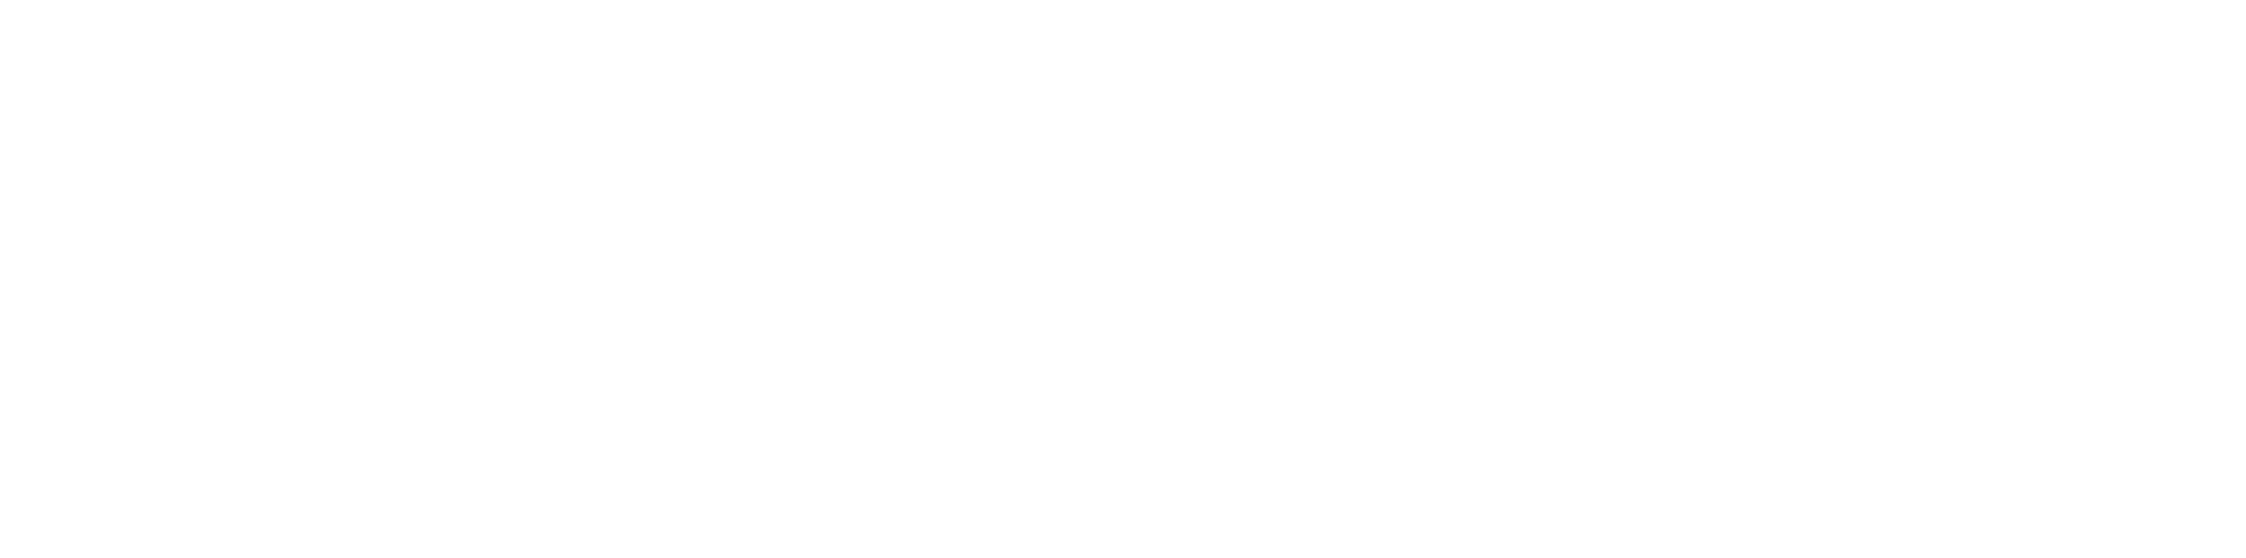

In [9]:
from matplotlib import pyplot as plt
from sklearn import tree


fig = plt.figure(figsize=(40,10))
_ = tree.plot_tree(mpipe.pipe.named_steps['Meta Model'].best_estimator_,
                   label='root',
                   class_names= ['not up', 'up'],
                   filled=True)